In [1]:
import torch
from matplotlib import pyplot as plt
# from tqdm.notebook import tqdm
import tqdm
import monotonenorm as lmn
import os
# pip install -e . in the directory with setup.py if you do not have monotonenorm installed
plt.style.use('mpl-config')

We will make a simple toy regression model to fit the following 1D function $$f(x) = \log(x) + \epsilon(x)$$
where $\epsilon$ is a gaussian noise term whose variance is linearly increasing in x. 
In this toy model we will assume that we have good reason to believe that the function we are trying to fit is monotonic (despite non-monotnic behavior of the noise). For example, we are building a trigger algorithm to discriminate between signal and background events. Rarer events are more likely to be signal and thus we should employ a network which is monotonic in some "rareness" feature. Another example could be a hiring classifier where (all else equal) higher school grades should imply better chances of being hired. 

Now we will fit an unconstrained model and monotonic Lipschitz model.

In [2]:
width = 128

class UnconstrainedModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
    torch.nn.Linear(1, width),
    torch.nn.ReLU(),
    torch.nn.Linear(width, width),
    torch.nn.ReLU(),
    torch.nn.Linear(width, width),
    torch.nn.ReLU(),
    torch.nn.Linear(width, 1),
)
    def forward(self, x):
        return self.model(x)

# Build a Lipschitz-1 network
class RobustModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            lmn.direct_norm(torch.nn.Linear(1, width), kind="one-inf"),
            lmn.GroupSort(2),
            lmn.direct_norm(torch.nn.Linear(width, width), kind="inf"),
            lmn.GroupSort(2),
            lmn.direct_norm(torch.nn.Linear(width, width), kind="inf"),
            lmn.GroupSort(2),
            lmn.direct_norm(torch.nn.Linear(width, 1), kind="inf"),
        )
        
    def forward(self, x):
        return self.model(x)

In [3]:
# Config
EPOCHS = 3000
N = 30           # Number of points 
loss_func = torch.nn.MSELoss()

path = os.path.join(os.getcwd(), "figures")
os.makedirs(path, exist_ok=True)

In [4]:
up = False
interp = False
y_list_fname = f"y_list_monotonicExample-Up{up}-Interp{interp}.pt"
y_robust_list_fname = f"y_robust_list_monotonicExample-Up{up}-Interp{interp}.pt"
# simple toy data
def gen_data(interp=False, up=False):
    seed = 20 if up else 18 # cherry picked seed for reproducibility
    torch.manual_seed(seed)
    max_range = 3   # Maximum range of x
    if interp == False:
        x_train = torch.linspace(1, max_range, N).view(-1, 1)
    else:
        x_train = torch.linspace(1, max_range, N//2).view(-1, 1)
        x_train = torch.cat([x_train, torch.linspace(1.5, 2, N//2).view(-1,1) * max_range], dim=0)
    true_model = lambda x: torch.log(x)
    y_train = true_model(x_train)
    # Adding linearly increasing noise
    y_error = torch.linspace(0.01, 0.3, N).view(-1, 1) 
    noise = torch.randn(N).view(-1, 1) * y_error
    y_train -= noise

    # PLOT DATA
    x_linspace = torch.linspace(1, max_range * 2, 2 * N).view(-1, 1)
    y_linspace = true_model(x_linspace)
    return x_train, y_train, x_linspace, y_linspace, y_error
x_train, y_train, x_linspace, y_linspace, y_error = gen_data(interp=interp, up=up)

In [5]:
y_list = []
y_robust_list = []
torch.manual_seed(0)
num_trials = 2

y_file = os.path.join(path, y_list_fname)
y_robust_file = os.path.join(path, y_robust_list_fname)
if os.path.exists(y_file) and os.path.exists(y_robust_file):
    y_list = torch.load(y_file)
    y_robust_list = torch.load(y_robust_file)
else:
    for i in range(num_trials):
        model = UnconstrainedModel()
        monotonic_model = lmn.SigmaNet(RobustModel(), 1)
        # SigmaNet is actually deprecated, but it's still here for now
        # Instead of using SigmaNet, you can use lmn.MonotonicWrapper
        optim = torch.optim.Adam([{"params" : model.parameters()}, {"params" : monotonic_model.parameters()}], lr=1e-2)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, EPOCHS)

        # Train both models at the same time
        pbar = tqdm.trange(EPOCHS)
        for i in pbar:
            y = model(x_train)
            y_robust = monotonic_model(x_train)
            loss = loss_func(y, y_train)
            loss_robust = loss_func(y_robust, y_train)
            loss_robust.backward()
            loss.backward()
            optim.step()
            scheduler.step()
            optim.zero_grad()
            pbar.set_description(
                f"epoch: {i} loss: {loss.item():.4f}, loss_robust: {loss_robust.item():.4f}")
            # Plot results
        with torch.no_grad():
            model.eval()
            y = model(x_linspace)
            y_robust = monotonic_model(x_linspace)
            y_list.append(y)
            y_robust_list.append(y_robust)
        # save lists
    torch.save(y_list, os.path.join(path, y_list_fname))
    torch.save(y_robust_list, os.path.join(path, y_robust_list_fname))

epoch: 512 loss: 0.0107, loss_robust: 0.0139:  17%|█▋        | 511/3000 [00:01<00:08, 294.49it/s]

epoch: 2999 loss: 0.0087, loss_robust: 0.0114: 100%|██████████| 3000/3000 [00:09<00:00, 303.74it/s]


In [6]:
# load lists
up = False
interp = False
y_list_fname = f"y_list_monotonicExample-Up{up}-Interp{interp}.pt"
y_robust_list_fname = f"y_robust_list_monotonicExample-Up{up}-Interp{interp}.pt"
y_list = torch.load(os.path.join(path, y_list_fname))
y_robust_list = torch.load(os.path.join(path, y_robust_list_fname))
x_train, y_train, x_linspace, y_linspace, y_error = gen_data(interp=interp, up=up)

Saved /home/submit/kitouni/projects/MonotoneNorm/Examples/figures/monotonic_dependence_unobserved_UpFalse_InterpFalse.png


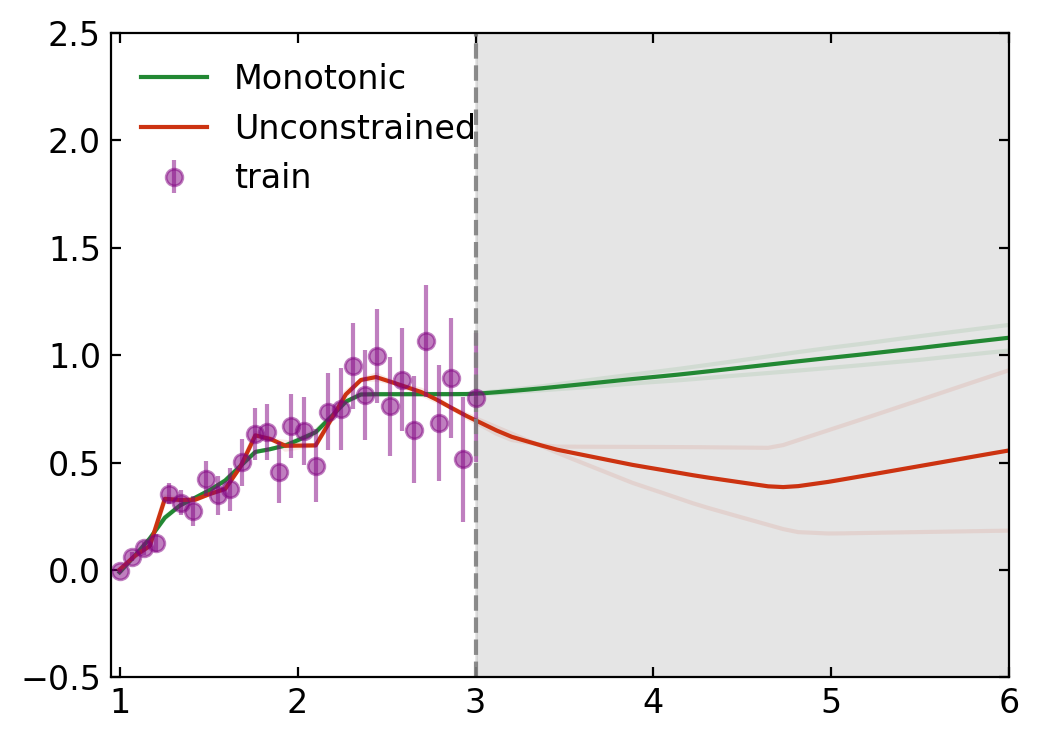

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), dpi=200)
for y, y_robust in zip(y_list, y_robust_list):
    ax.plot(x_linspace.numpy(), y_robust.numpy(), color='C1', alpha=0.1)
    ax.plot(x_linspace.numpy(), y.numpy(), color='C2', alpha=0.1)
# plot mean
ax.plot(x_linspace.numpy(), torch.hstack(y_robust_list).mean(1).numpy(), color='C1', label='Monotonic')
ax.plot(x_linspace.numpy(), torch.hstack(y_list).mean(1).numpy(), color='C2', label='Unconstrained')

# plt.plot(x_linspace, y_linspace, c='gray',
#          linestyle='--', alpha=0.9, label="true function")
plt.errorbar(x_train.numpy().flatten(), y_train.numpy().flatten(), 
    yerr=y_error.numpy().flatten(), fmt='o', c='purple', label='train', alpha=0.5)
plt.legend(loc='upper left')
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(1-0.05,6)
if interp:
    ax.axvline(3, c='gray', linestyle='--', alpha=0.9)
    ax.axvline(4.5, c='gray', linestyle='--', alpha=0.9)
    ax.fill_betweenx([-0.5, 2.5], 3, 4.5, color='gray', alpha=0.2)
else:
    ax.axvline(3, c='gray', linestyle='--', alpha=0.9)
    ax.fill_betweenx([-2, 3], 3, 6, color='gray', alpha=0.2)
figname = f"monotonic_dependence_unobserved_Up{up}_Interp{interp}.png"
figname = os.path.join(path, figname)
plt.tight_layout(pad=0)
plt.savefig(figname)
print("Saved", figname)
plt.show()

Now we will make a different toy model with one noisy data point. This will show that the Lipschitz continuous network is more robust against outliers than an unconstrained network because its gradient with respect to the input is bounded between -1 and 1. Additionally, it is more robust against adversarial attacks/data corruption for the same reason.

In [8]:
def gen_data2(N):
    torch.manual_seed(4)
    x_train = torch.linspace(-3, 3, N).view(-1, 1)

    y_train_error = torch.ones(N).view(-1, 1) * 0.01
    y_train_error[N // 2] = 1
    y_train = torch.sin(x_train) + torch.randn(N).view(-1, 1) * y_train_error

    # PLOT DATA
    x_linspace = torch.linspace(-3, 3, 2 * N).view(-1, 1)
    y_linspace = torch.sin(x_linspace)
    return x_train, y_train, x_linspace, y_linspace, y_train_error
x_train, y_train, x_linspace, y_linspace, y_error = gen_data2(31)

In [11]:
# Now we will make a simple function
torch.manual_seed(0)
loss_func = torch.nn.L1Loss()
y_file = os.path.join(path, "y_list_robustExample.pt")
y_robust_file = os.path.join(path, "y_robust_list_robustExample.pt")
if os.path.exists(y_file) and os.path.exists(y_robust_file):
    y_list = torch.load(y_file)
    y_robust_list = torch.load(y_robust_file)
else:
    y_list = []
    y_robust_list = []
    num_trials = 2
    for _ in range(num_trials):
        pbar = tqdm.trange(EPOCHS)
        model = UnconstrainedModel()
        robust_model = RobustModel()
        optim = torch.optim.Adam([{"params" : model.parameters()}, {"params" : robust_model.parameters()}], lr=1e-1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, EPOCHS)
        for i in pbar:
            y = model(x_train)
            y_robust = robust_model(x_train)
            loss = torch.mean(loss_func(y, y_train))
            loss_robust = loss_func(y_robust, y_train)
            loss_robust.backward()
            loss.backward()
            optim.step()
            scheduler.step()
            optim.zero_grad()
            pbar.set_description(
                f"epoch: {i} loss: {loss.item():.4f}, loss_robust: {loss_robust.item():.4f}")

        with torch.no_grad():
            y = model(x_linspace)
            y_robust = robust_model(x_linspace)
            y_list.append(y)
            y_robust_list.append(y_robust)
    # save lists
    torch.save(y_list, y_file)
    torch.save(y_robust_list, y_robust_file)

Saved figures/robust_against_noisy_outlier.png


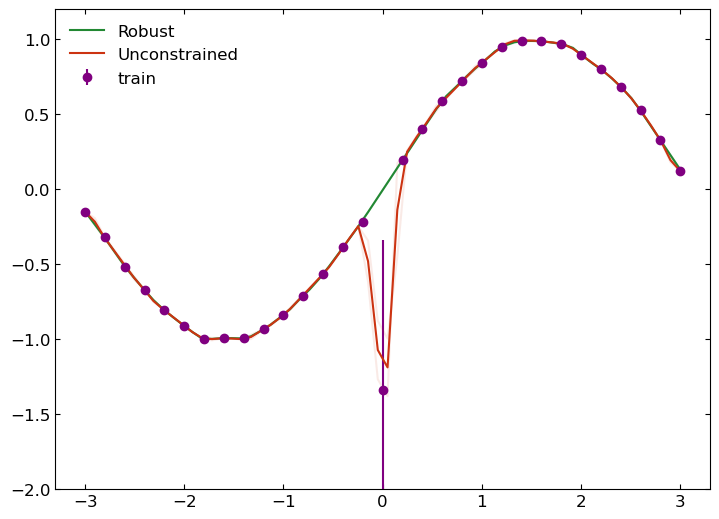

In [12]:
# load lists
y_list = torch.load(y_file)
y_robust_list = torch.load(y_robust_file)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.errorbar(x_train.numpy().flatten(), y_train.numpy().flatten(), yerr=y_error.numpy().flatten(), fmt='o', c='purple', label='train')
for y, y_robust in zip(y_list, y_robust_list):
    ax.plot(x_linspace.numpy(), y_robust.numpy(), color='C1', alpha=0.1)
    ax.plot(x_linspace.numpy(), y.numpy(), color='C2', alpha=0.1)
# plot mean
ax.plot(x_linspace.numpy(), torch.hstack(y_robust_list).mean(1).numpy(), color='C1', label='Robust')
ax.plot(x_linspace.numpy(), torch.hstack(y_list).mean(1).numpy(), color='C2', label='Unconstrained')

# plt.plot(x_linspace, y_linspace, c='gray',
        #  linestyle='--', alpha=0.9, label="true function")
plt.legend()
figname = "figures/robust_against_noisy_outlier.png"
plt.ylim(-2, 1.2)
plt.tight_layout(pad=0)
plt.savefig(figname)
print("Saved", figname)
plt.show()